# Investigating digit-by-digit learning

This notebook looks into the "steps" visible in the loss curve where the models seems to learn one digit at a time.

Here is the training curves for NanoGPT on 7x7 addition with answer zero padding:

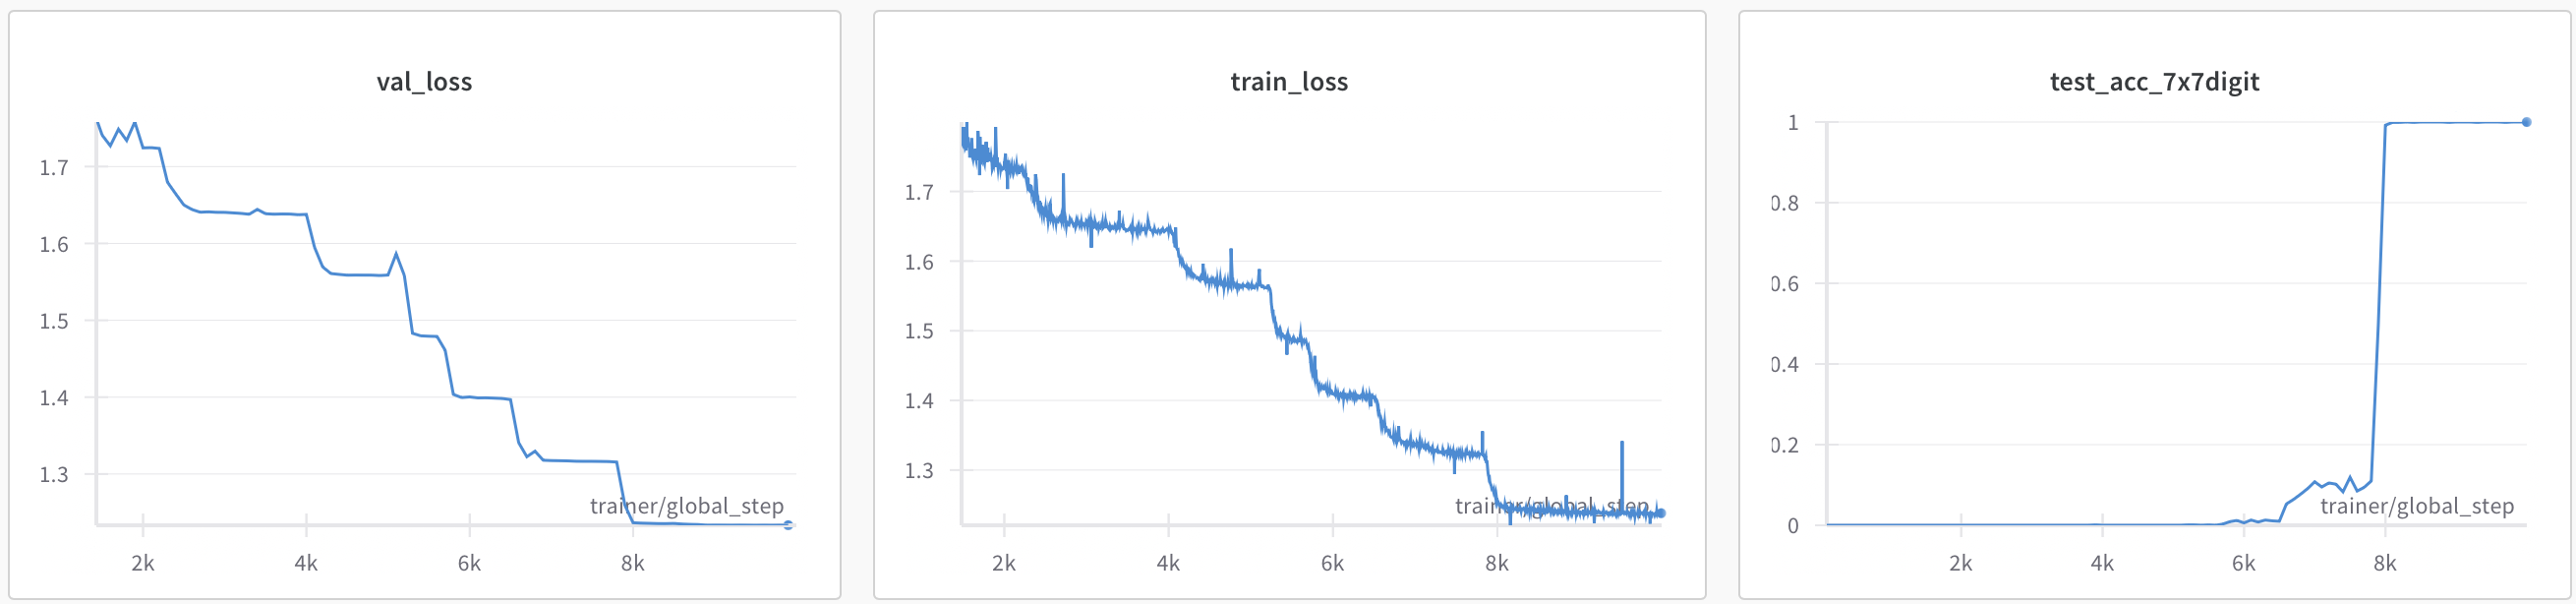

In [14]:
import json
from pathlib import Path

import wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from arithmetic_lm.constants import PLOTS_DIR


%matplotlib inline

In [15]:
WANDB_ENTITY = "compositional-generalization-ut"

## Functions

In [16]:
def process_table_json(path) -> pd.DataFrame:
    with open(Path(path) / "samples.table.json", "r") as f:
        table = json.load(f)
    df = pd.DataFrame(table["data"], columns=table["columns"])
    return df

In [17]:
def how_many_correct(answer: str, pred_answer: str) -> int:
    """Count how many digits from the right are correct"""
    # keep only digits in the answer
    answer = "".join([c for c in answer if c.isdigit()])
    pred_answer = "".join([c for c in pred_answer if c.isdigit()])
    if not pred_answer:
        return 0
    for i, (a, p) in enumerate(zip(answer[::-1], pred_answer[::-1])):
        if a != p:
            return i
    return len(answer)

In [18]:
def plot_hist(
    train_loss,
    val_loss,
    n_correct_digits,
    test_acc,
    suptitle,
    figname,
    loss_drops: list[int] = [],
    show_val_loss: bool = True,
):

    fig, ax = plt.subplots(3, 1, figsize=(5, 7), sharex=True)

    ax[0].plot(train_loss, linewidth=2, label="train")
    if show_val_loss:
        ax[0].plot(val_loss, linewidth=2, label="val")
    ax[0].grid(alpha=0.5, linestyle="--", axis="y")
    ax[0].xaxis.set_tick_params(labelbottom=True)
    ax[0].set_title("Loss")
    ax[0].legend()

    ax[1].plot(n_correct_digits, linewidth=2)
    ax[1].set_yticks(np.arange(0, 9))
    ax[1].grid(alpha=0.5, linestyle="--", axis="y")
    ax[1].xaxis.set_tick_params(labelbottom=True)
    ax[1].set_title(
        "Median number of consecutive correct digits in \npredicted answer (counted from the right, i.e. MSD)"
    )

    ax[2].plot(test_acc, linewidth=2)
    ax[2].grid(alpha=0.5, linestyle="--", axis="y")
    ax[2].xaxis.set_tick_params(labelbottom=True)
    ax[2].set_title("Test accuracy")
    ax[2].set_xlabel("Step")

    # vertical lines for loss step drops
    for loss_drop in loss_drops:
        for axi in ax:
            axi.axvline(
                loss_drop, color="red", linestyle="--", alpha=0.3, label="loss drop"
            )

    # to add loss drop labels
    ax[0].legend()
    # remove duplicates
    handles, labels = ax[0].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax[0].legend(by_label.values(), by_label.keys())

    fig.suptitle(suptitle)
    plt.tight_layout()
    plt.savefig(
        PLOTS_DIR / figname,
        dpi=120,
        bbox_inches="tight",
    )
    plt.show()

In [19]:
def plot_run_history_digits(
    wandb_project: str,
    wandb_run_id: str,
    suptitle: str,
    figname: str,
    min_step: int | None = 1000,
    max_step: int | None = None,
    loss_drops: list[int] = [],
    show_val_loss: bool = True,
):

    # init run
    api = wandb.Api()
    run = api.run(f"{WANDB_ENTITY}/{wandb_project}/{wandb_run_id}")

    # get history
    full_history = pd.DataFrame(run.scan_history())

    history = full_history[
        [
            "trainer/global_step",
            "train_loss",
            "val_loss",
            "test_acc_7x7digit",
            "samples",
        ]
    ]
    print(f"History shape: {history.shape}")

    # rename "trainer/global_step" to "step"
    history = history.rename(columns={"trainer/global_step": "step"})

    # set step as index
    history = history.set_index("step")

    # get tables for the run
    tables = []
    artifacts = run.logged_artifacts(per_page=10000)
    for art in artifacts:
        if art.type == "run_table":
            art_path = Path("artifacts") / art.name
            if not art_path.exists():
                art.download()
            tables.append(art_path)

    print(f"Number of tables: {len(tables)}")

    # clear cell output
    from IPython.display import clear_output

    clear_output()

    # get steps where tables were logged from samples column
    tables_steps = history["samples"].dropna().index
    assert len(tables) == len(tables_steps), (
        f"Number of tables and tables_steps do not match ({len(tables)} and {len(tables_steps)}), tables_steps: "
        + str(tables_steps)
    )

    predictions = {}
    for ts, table in zip(tables_steps, tables):
        predictions[ts] = process_table_json(table)

    predictions = (
        pd.concat(predictions, names=["step"])
        .reset_index(level=0)
        .reset_index(drop=True)
    )

    predictions["n_correct_digits"] = predictions.apply(
        lambda x: how_many_correct(x["answer"], x["pred_answer"]), axis=1
    )

    print(predictions)

    n_correct_digits = predictions.groupby("step")["n_correct_digits"].median()

    train_loss = history["train_loss"].dropna().loc[min_step:max_step]
    val_loss = history["val_loss"].dropna().loc[min_step:max_step]
    test_acc = history["test_acc_7x7digit"].dropna().loc[min_step:max_step]
    n_correct_digits = n_correct_digits.loc[min_step:max_step]

    plot_hist(
        train_loss,
        val_loss,
        n_correct_digits,
        test_acc,
        suptitle=suptitle,
        figname=figname,
        loss_drops=loss_drops,
        show_val_loss=show_val_loss,
    )

## Exp. 6: 7x7 addition - NanoGPT

Reversed answer, 0 padding answer to 8 digits

     step            dataset                 prompt         answer  \
0       4      test_7x7digit  '\n$2718005+1660515='  '02587340$\n'   
1       4      test_7x7digit  '\n$3111679+8743366='  '54055811$\n'   
2       4      test_7x7digit  '\n$6022535+6844124='  '95666821$\n'   
3       4  test_train_subset  '\n$7205747+5914501='  '84202131$\n'   
4       4  test_train_subset  '\n$6089386+7726580='  '66951831$\n'   
..    ...                ...                    ...            ...   
601  9999      test_7x7digit  '\n$9590634+8302340='  '47929871$\n'   
602  9999      test_7x7digit  '\n$6548229+6592431='  '06604131$\n'   
603  9999  test_train_subset  '\n$6590820+2180440='  '06217780$\n'   
604  9999  test_train_subset  '\n$9835677+6682985='  '26681561$\n'   
605  9999  test_train_subset  '\n$9788857+3132322='  '97112921$\n'   

       pred_answer  correct  n_correct_digits  
0     '=========='    False                 0  
1     '=========='    False                 0  
2     '========

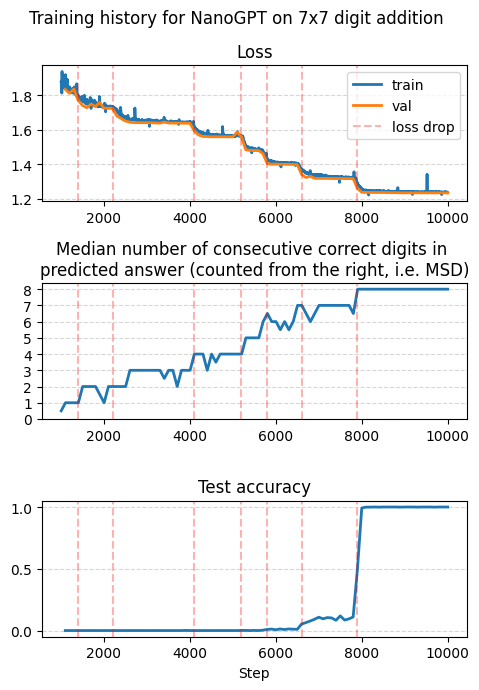

In [20]:
plot_run_history_digits(
    wandb_project="addition-7x7-digit-pad-ans-zero",
    wandb_run_id="24jagq4h",
    suptitle="Training history for NanoGPT on 7x7 digit addition",
    figname="exp_6_7x7_addition_nanogpt_digit_learning.png",
    min_step=1000,
    max_step=None,
    loss_drops=[1400, 2200, 4100, 5200, 5800, 6600, 7900],
)

## Exp. 6: 7x7 addition - Transformer

Reversed answer, 0 padding answer to 8 digits

       step            dataset                prompt          answer  \
0         4      test_7x7digit  '\n$2718005+1660515'  '=02587340$\n'   
1         4      test_7x7digit  '\n$3111679+8743366'  '=54055811$\n'   
2         4      test_7x7digit  '\n$6022535+6844124'  '=95666821$\n'   
3         4  test_train_subset  '\n$9871478+5052968'  '=64442941$\n'   
4         4  test_train_subset  '\n$6441658+3824479'  '=73166201$\n'   
...     ...                ...                   ...             ...   
1219  20304      test_7x7digit  '\n$1204756+7703318'  '=47080980$\n'   
1220  20304      test_7x7digit  '\n$7873967+2713843'  '=01878501$\n'   
1221  20304  test_train_subset  '\n$8089494+9773028'  '=22526871$\n'   
1222  20304  test_train_subset  '\n$9070306+7741949'  '=55221861$\n'   
1223  20304  test_train_subset  '\n$4471182+8153106'  '=88242621$\n'   

        pred_answer  correct  n_correct_digits  
0     '==========='    False                 0  
1     '==========='    False         

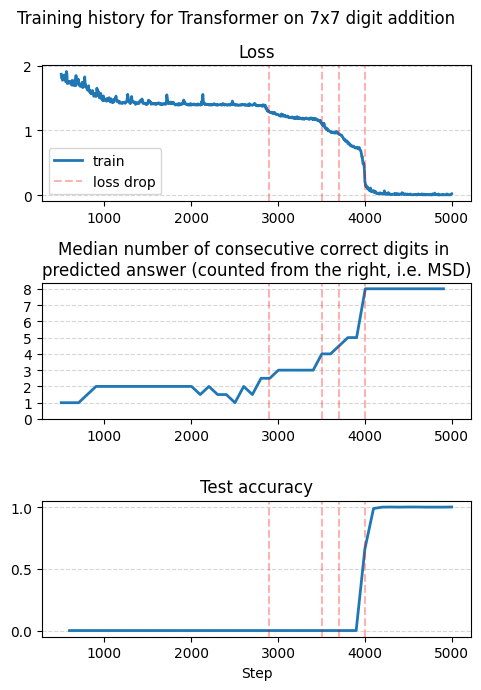

In [23]:
plot_run_history_digits(
    wandb_project="addition-7x7-digit-pad-ans-zero",
    wandb_run_id="3osjwy9h",
    suptitle="Training history for Transformer on 7x7 digit addition",
    figname="exp_6_7x7_addition_transformer_digit_learning.png",
    min_step=500,
    max_step=5000,
    loss_drops=[2900, 3500, 3700, 4000],
    show_val_loss=False,
)

       step            dataset                prompt          answer  \
0         4      test_7x7digit  '\n$2718005+1660515'  '=02587340$\n'   
1         4      test_7x7digit  '\n$3111679+8743366'  '=54055811$\n'   
2         4      test_7x7digit  '\n$6022535+6844124'  '=95666821$\n'   
3         4  test_train_subset  '\n$3495508+3921028'  '=63561470$\n'   
4         4  test_train_subset  '\n$3244695+5066150'  '=54801380$\n'   
...     ...                ...                   ...             ...   
1801  29999      test_7x7digit  '\n$4101009+1729228'  '=73203850$\n'   
1802  29999      test_7x7digit  '\n$7001617+9531291'  '=80923561$\n'   
1803  29999  test_train_subset  '\n$1372395+8071972'  '=76344490$\n'   
1804  29999  test_train_subset  '\n$5042134+2785107'  '=14272870$\n'   
1805  29999  test_train_subset  '\n$1455238+2764697'  '=53991240$\n'   

        pred_answer  correct  n_correct_digits  
0     '==========='    False                 0  
1     '==========='    False         

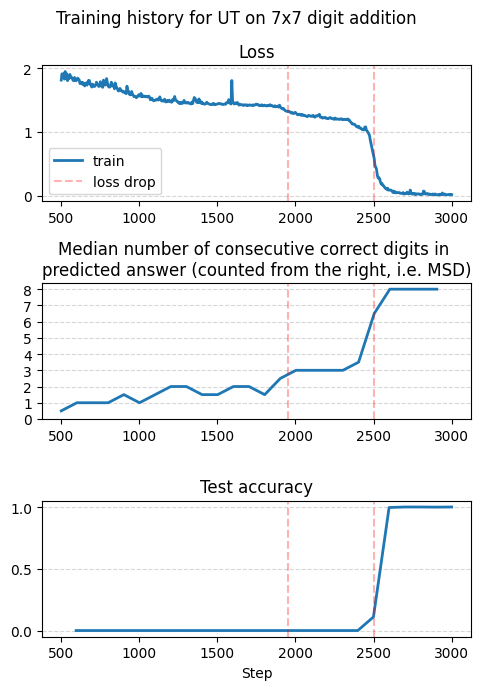

In [24]:
plot_run_history_digits(
    wandb_project="addition-7x7-digit-pad-ans-zero",
    wandb_run_id="vjl3u8c4",
    suptitle="Training history for UT on 7x7 digit addition",
    figname="exp_6_7x7_addition_ut_digit_learning.png",
    min_step=500,
    max_step=3000,
    loss_drops=[1950, 2500],
    show_val_loss=False,
)